# Loading necessary Libraries

In [1]:
import cv2
import pytesseract
import imutils
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
import pickle

import os

2024-09-08 15:11:06.556855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 15:11:06.672238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 15:11:06.706507: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 15:11:06.904059: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 15:11:08.420868: W tensorflow/compiler/tf2

# Creating or importing the model (CNN)

## Loading the model :

In [2]:
if os.path.exists("model.h5"):
    model = keras.models.load_model("model.h5")
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print("Model loaded")
    print(model.summary())
else:
    print("Model Not found")

I0000 00:00:1725804670.642713    5584 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725804670.852955    5584 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725804670.853292    5584 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725804670.855529    5584 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model loaded


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,274 (520.60 KB)

 Trainable params: 132,826 (518.85 KB)

 Non-trainable params: 448 (1.75 KB)

None


## New model : 

### Loading the data

In [12]:
# if not os.path.exists("model.h5"):
print("Loading Data...")
dataset = pd.read_csv("A_Z Handwritten Data/A_Z Handwritten Data.csv").astype('float16')
dataset.rename(columns={'0':'label'}, inplace=True)

X_tmp = dataset.drop('label',axis = 1)
Y = dataset['label']
X = [np.reshape(list(X_tmp.loc[i]), (28,28)) for i in range(len(dataset))]

print("Data Loaded Succefully!")

Loading Data...
Data Loaded Succefully!


### Training the model

In [13]:
if not os.path.exists("model.h5"):
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.15, shuffle=True)
    # Convert arrays to float16
    X_train = np.array(X_train, dtype=np.float16)
    y_train = np.array(y_train, dtype=np.float16)
    X_test = np.array(X_test, dtype=np.float16)
    y_test = np.array(y_test, dtype=np.float16)

    # Setting the encoder for the labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Saving the dictionnary for letters
    # dictionnary = dict(zip(np.unique(y_test_encoded), np.unique(y_train)))

    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    y_train_encoded = y_train_encoded.astype('int')
    y_test_encoded = y_test_encoded.astype('int')

    num_label = len(np.unique(y_train_encoded))

    # Check data shapes
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # Setting the model layers 
    model = keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_label, activation='softmax')
    ])
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train_encoded, epochs=20, batch_size=10, validation_data=(X_test, y_test_encoded))

    # Evaluating the model accuracy and loss
    test_loss,test_acc = model.evaluate(X_test,y_test_encoded)  

    # saving the model :
    model.save("model.h5")

    print("test accuracy : ",test_acc)
    print("test loss : ",test_loss)
    
    # saving the model :
    model.save("model.h5")
else:
    print("Model Loaded no need to train again")

X_train shape: (316582, 28, 28), y_train shape: (316582,)
X_test shape: (55868, 28, 28), y_test shape: (55868,)


/home/aymen/miniconda3/envs/Ai-ML/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-08 15:13:50.900660: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 992801152 exceeds 10% of free system memory.
2024-09-08 15:13:51.656498: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 992801152 exceeds 10% of free system memory.


Epoch 1/20
31659/31659 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - accuracy: 0.9047 - loss: 0.3393 - val_accuracy: 0.9776 - val_loss: 0.0813
Epoch 2/20
31659/31659 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - accuracy: 0.9686 - loss: 0.1129 - val_accuracy: 0.9802 - val_loss: 0.0721
Epoch 3/20
31659/31659 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.9756 - loss: 0.0861 - val_accuracy: 0.9821 - val_loss: 0.0665
Epoch 4/20
31659/31659 ━━━━━━━━━━━━━━━━━━━━ 64s 2ms/step - accuracy: 0.9798 - loss: 0.0720 - val_accuracy: 0.9834 - val_loss: 0.0642
Epoch 5/20
31659/31659 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step - accuracy: 0.9812 - loss: 0.0675 - val_accuracy: 0.9842 - val_loss: 0.0628
Epoch 6/20
31659/31659 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step - accuracy: 0.9826 - loss: 0.0619 - val_accuracy: 0.9863 - val_loss: 0.0528
Epoch 7/20
31659/31659 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.9838 - loss: 0.0577 - val_accuracy: 0.9862 - val_loss: 0.0557
Epoch 8/20
31659/31659 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 

test accuracy :  0.9888129234313965
test loss :  0.0577191524207592


# Contouring the Letters of the word

## Used functions

In [14]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def get_letters(img):
    image = cv2.imread(img)
    image = cv2.resize(image, (324, 44), interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    # Initialize an empty list to store the characters (ROIs)
    characters = []
    
    padding = 5
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            
            # Draw rectangle with padding
            cv2.rectangle(image, (x - padding, y - padding), 
                        (x + w + padding, y + h + padding), (255, 0, 0), 1)
            
            # Adjust coordinates for padding
            x_pad, y_pad = max(0, x - padding), max(0, y - padding)
            w_pad, h_pad = x + w + padding - x_pad, y + h + padding - y_pad
            
            # Extract the ROI with padding
            roi = gray[y_pad:y_pad + h_pad, x_pad:x_pad + w_pad]
            
            # Apply threshold to get the binary image for each letter
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            
            # Resize to (28, 28) to make each letter uniform
            resized_thresh = cv2.resize(thresh, (28, 28), interpolation=cv2.INTER_CUBIC)
            
            # Normalize and reshape for further processing
            resized_thresh = resized_thresh.astype("float32") / 255.0
            resized_thresh = np.expand_dims(resized_thresh, axis=-1)  # Add channel dimension
            resized_thresh = resized_thresh.reshape(1, 28, 28, 1)
            
            # Add the letter to the characters list
            characters.append(resized_thresh)

    return characters, image


## Displaying characters :

In [15]:
image_name = "aymen.png"
original_image = cv2.imread(image_name)
print(original_image.shape)
characters, image_contours = get_letters(image_name)

(496, 1161, 3)


### Original Word

Text(0.5, 1.0, 'Contoured image')

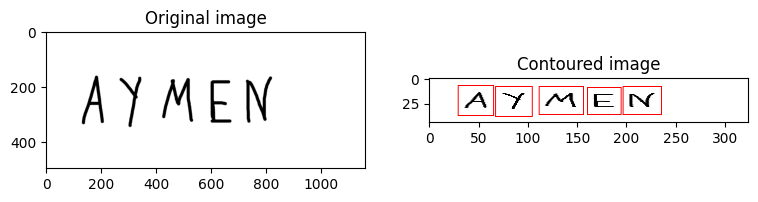

In [16]:
plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Original image")

plt.subplot(1,3,2)
plt.imshow(image_contours, cmap="gray")
plt.title("Contoured image")

### Each Character

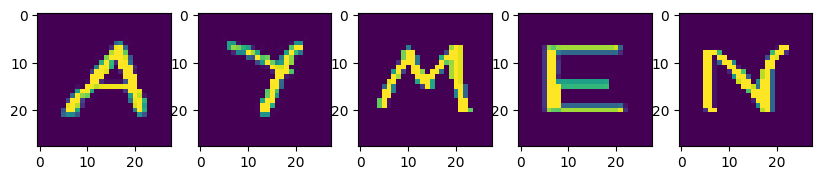

In [17]:

# Create a figure with an appropriate size
plt.figure(figsize=(10, 2))

# Loop through each character and plot it
for i, car in enumerate(characters):
    # Extract the 2D image from the 4D tensor
    car_image = car[0, :, :, 0]  # Remove the batch and channel dimensions
    
    # Create a subplot for each character
    plt.subplot(1, len(characters), i + 1)
    plt.imshow(car_image)

# Display the plot
plt.show()


# Implmenting the model with the characters

(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


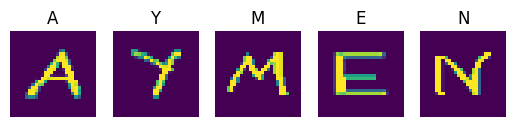

In [18]:
ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for i, car in enumerate(characters):
    car_image = car[0, :, :, 0]
    car_image_reshaped = car_image.reshape((1, 28, 28, 1))
    print(car_image_reshaped.shape)
    prediction = model.predict(car_image_reshaped)
    result = ALPHABET[np.argmax(prediction)]
    plt.subplot(1, len(characters), i + 1)
    plt.imshow(car_image)
    plt.title(result)
    plt.axis(False)

# Final Result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Text(0.5, 1.0, 'Predicted Value : AYMEN')

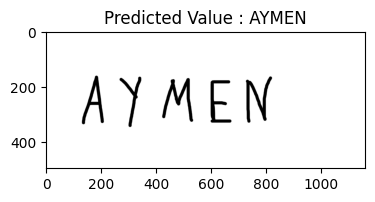

In [19]:
original_image = cv2.imread(image_name)
characters, image_contours = get_letters(image_name)
final_result = ""
for i, car in enumerate(characters):
    car_image = car[0, :, :, 0]
    car_image_reshaped = car_image.reshape((1, 28, 28, 1))
    prediction = model.predict(car_image_reshaped)
    final_result += ALPHABET[np.argmax(prediction)]
    
plt.figure(figsize=(14,6))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Predicted Value : "+final_result)